In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

def poisson_random_process(lmbda, total_time):
    """
    Generate a Poisson random process.
    
    Parameters:
        lmbda (float): The parameter lambda of the Poisson distribution.
        total_time (float): The total time for the process.
    
    Returns:
        numpy.ndarray: An array of timestamps when events occur.
    """
    num_events = np.random.poisson(lmbda * total_time)
    event_times = np.cumsum(np.random.exponential(1 / lmbda, num_events))
    event_times = event_times[event_times < total_time]
    return event_times



In [7]:
gen_rate = 1e6 # Parameter lambda in Hz
total_time = 5e-3  # Total time in sec for the process
fdl_list = np.logspace(-9,-3,10) # delay line time quantization in sec
# tolerance_list = np.logspace(-10,-8,4) 
tolerance_list = np.arange(.2,1.1,.2)*1e-9 

Nrep = 1000
succ_rate = np.zeros((len(tolerance_list),len(fdl_list), Nrep))
for i_t, tolerance in enumerate(tolerance_list):
    # print(i_t, end="\r")
    for i_f, fdl in enumerate(fdl_list):
        tic = time.time()
        for i_r in range(Nrep):
            # print(i_r, end="\r")
            s1 = poisson_random_process(gen_rate, total_time)
            s2 = poisson_random_process(gen_rate, total_time)

            num_trials = min(s1.shape[0],s2.shape[0])
            # num_trials
            all_events = np.concatenate((s1,s2))
            events_inds = all_events.argsort()
            all_events = all_events[events_inds]
            emissions = np.zeros(events_inds.shape[0])
            emissions[np.argwhere(events_inds>=s1.shape[0])] = 1
            # print(emissions[:40])
            # plt.plot(emissions,".")

            # second_tick = np.argwhere(np.abs(np.diff(emissions))>0)[:,0]+1
            # print(second_tick[:10])
            # # for i in range(1,second_tick.shape[0]):
            # num_coincidences = np.sum(np.abs(np.diff(emissions))>0)

            coincident_events = []
            coincident_inds = []
            time_diff = []

            i1 = 0
            photon1 = emissions[i1]
            for _ in range(num_trials):
                # if second_tick[i]> second_tick[i-1]+1:
                #     # second_tick[i]+1:second_tick[i-1]
                #     i1 = second_tick[i-1]+1
                #     i2 = second_tick[i]
                #     print((i1,i2),emissions[[i1,i2]],all_events[[i1,i2]])
                next_event = np.argwhere(emissions[i1+1:]== 1- photon1)
                if len(next_event)>0:
                    i2 = i1+ next_event[0,0] +1 
                    photon2 = emissions[i2]
                    # print((i1,i2),emissions[[i1,i2]],all_events[[i1,i2]])
                    assert all_events[i2]-all_events[i1]>0
                    time_diff.append(all_events[i2]-all_events[i1])
                    coincident_inds.append((i1,i2))
                    coincident_events.append(emissions[[i1,i2]].tolist())
                    i1 = i2 + 1
                    if i1 < len(emissions):
                        photon1 = emissions[i1]
                    else:
                        break
                else:
                    break

            # print(np.sum( (np.array(time_diff) % fdl)< tolerance)/len(time_diff))
            succ_rate[i_t,i_f,i_r] = np.sum( (np.array(time_diff) % fdl)< tolerance)/total_time
        toc = time.time()
        print(f"({i_t},{i_f}), elapsed time {toc-tic} sec")

# succ_rate /= Nrep

(0,0), elapsed time 74.00574254989624 sec
(0,1), elapsed time 73.17426371574402 sec
(0,2), elapsed time 73.54819655418396 sec
(0,3), elapsed time 73.21048855781555 sec
(0,4), elapsed time 74.0461196899414 sec
(0,5), elapsed time 73.11804366111755 sec
(0,6), elapsed time 73.7433705329895 sec
(0,7), elapsed time 73.41698098182678 sec
(0,8), elapsed time 73.37714838981628 sec
(0,9), elapsed time 73.83711695671082 sec
(1,0), elapsed time 73.65831303596497 sec
(1,1), elapsed time 74.09402465820312 sec
(1,2), elapsed time 74.2874448299408 sec
(1,3), elapsed time 74.16887903213501 sec
(1,4), elapsed time 73.72432661056519 sec
(1,5), elapsed time 74.0327365398407 sec
(1,6), elapsed time 74.13790035247803 sec
(1,7), elapsed time 74.04822301864624 sec
(1,8), elapsed time 74.12455534934998 sec
(1,9), elapsed time 73.51623177528381 sec
(2,0), elapsed time 73.84860372543335 sec
(2,1), elapsed time 73.6521463394165 sec
(2,2), elapsed time 73.80221843719482 sec
(2,3), elapsed time 73.80249309539795 s

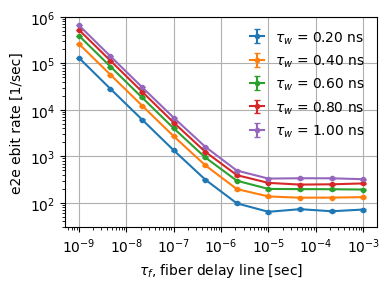

In [14]:
plt.figure(figsize=(4,3))
for i_t, tolerance in enumerate(tolerance_list):
    plt.errorbar(fdl_list, succ_rate[i_t,:,:].mean(axis=1), succ_rate[i_t,:,:].std(axis=1)/Nrep**0.5, fmt=".-", capsize=2, color = f"C{i_t}", label=fr"$\tau_w$ = {tolerance*1e9:.2f} ns")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\tau_f$, fiber delay line [sec]")
plt.ylabel("e2e ebit rate [1/sec]")
plt.ylim([3e1,1e6])
plt.legend(frameon=False, handlelength=1)
plt.grid()
plt.tight_layout()
plt.savefig("figures/rate_vs_delay.pdf")
plt.show()

In [16]:
fname = f"results/rates_vs_delay.npz"
np.savez(fname,gen_rate, total_time,
         fdl_list,tolerance_list,
         succ_rate)

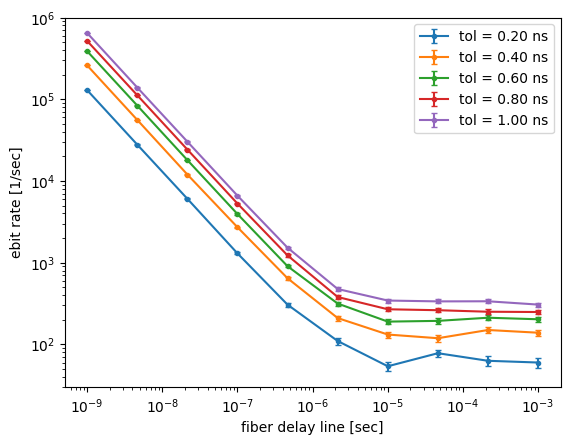

In [6]:
for i_t, tolerance in enumerate(tolerance_list):
    plt.errorbar(fdl_list, succ_rate[i_t,:,:].mean(axis=1), succ_rate[i_t,:,:].std(axis=1)/Nrep**0.5, fmt=".-", capsize=2, color = f"C{i_t}", label=f"tol = {tolerance*1e9:.2f} ns")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("fiber delay line [sec]")
plt.ylabel("ebit rate [1/sec]")
plt.ylim([3e1,1e6])
plt.legend()
plt.show()

# impact of photon loss

In [20]:
loss_switch = 10**(-0.1*0.5)
trans = lambda t: 10**(-0.02*2e5*t)

gen_rate = 1e6 # Parameter lambda in Hz
total_time = 1e-3  # Total time in sec for the process
fdl_list = np.logspace(-9,-5.2,30) # delay line time quantization in sec
# tolerance_list = np.logspace(-10,-8,4) 
tolerance_list = np.arange(.2,1.1,.4)*1e-9 

Nrep = 10000
succ_rate = np.zeros((len(tolerance_list),len(fdl_list), Nrep))
trans_prob = np.ones((len(tolerance_list),len(fdl_list), Nrep))
for i_t, tolerance in enumerate(tolerance_list):
    # print(i_t, end="\r")
    for i_f, fdl in enumerate(fdl_list):
        tic = time.time()
        for i_r in range(Nrep):
            # print(i_r, end="\r")
            s1 = poisson_random_process(gen_rate, total_time)
            s2 = poisson_random_process(gen_rate, total_time)

            num_trials = min(s1.shape[0],s2.shape[0])
            # num_trials
            all_events = np.concatenate((s1,s2))
            events_inds = all_events.argsort()
            all_events = all_events[events_inds]
            emissions = np.zeros(events_inds.shape[0])
            emissions[np.argwhere(events_inds>=s1.shape[0])] = 1

            coincident_events = []
            coincident_inds = []
            time_diff = []
            accepted_ids = []

            i1 = 0
            photon1 = emissions[i1]
            # coincident_counter = 0
            for i_trial in range(num_trials):
                next_event = np.argwhere(emissions[i1+1:]== 1- photon1)
                if len(next_event)>0:
                    i2 = i1+ next_event[0,0] +1 
                    photon2 = emissions[i2]
                    dt = all_events[i2]-all_events[i1]
                    time_diff.append(dt)
                    assert dt>0
                    coincident_inds.append((i1,i2))
                    coincident_events.append(emissions[[i1,i2]].tolist())
                    dt_detector = dt-(dt//fdl+1)*fdl
                    if abs(dt-(dt//fdl+1)*fdl) < tolerance:
                        # coincident_counter += 1
                        accepted_ids.append(i_trial)
                    i1 = i2 + 1
                    if i1 < len(emissions):
                        photon1 = emissions[i1]
                    else:
                        break
                else:
                    break
                
            time_diff = np.array(time_diff)
            # print(time_diff[accepted_ids], coincident_counter)
            # # print(time_diff.shape)
            # # print(np.sum( (np.array(time_diff) % fdl)< tolerance)/len(time_diff))
            # accepted_ids = np.argwhere((time_diff % fdl)< tolerance)[:,0]
            # succ_rate[i_t,i_f,i_r] = accepted_ids.shape[0]/total_time
            succ_rate[i_t,i_f,i_r] = len(accepted_ids)/total_time
            if succ_rate[i_t,i_f,i_r]>0:
                trans_prob[i_t,i_f,i_r] = np.mean(loss_switch**(time_diff[accepted_ids]//fdl)*trans((time_diff[accepted_ids]//fdl+1)*fdl))
            # print(time_diff[accepted_ids]//fdl, loss_switch**(time_diff[accepted_ids]//fdl))
            # print(time_diff[accepted_ids],trans(time_diff[accepted_ids]))
        toc = time.time()
        print(f"({i_t},{i_f}), elapsed time {toc-tic} sec")

# succ_rate /= Nrep
# print(trans_prob.mean(axis=2))

(0,0), elapsed time 80.9530143737793 sec
(0,1), elapsed time 80.76633810997009 sec
(0,2), elapsed time 80.57585549354553 sec
(0,3), elapsed time 80.74143099784851 sec
(0,4), elapsed time 80.52893805503845 sec
(0,5), elapsed time 80.62862944602966 sec
(0,6), elapsed time 80.4730076789856 sec
(0,7), elapsed time 80.55531358718872 sec
(0,8), elapsed time 80.31344389915466 sec
(0,9), elapsed time 79.94299530982971 sec
(0,10), elapsed time 80.20218586921692 sec
(0,11), elapsed time 80.19792151451111 sec
(0,12), elapsed time 79.77267837524414 sec
(0,13), elapsed time 79.57116341590881 sec
(0,14), elapsed time 80.00829553604126 sec
(0,15), elapsed time 79.74454283714294 sec
(0,16), elapsed time 79.88639950752258 sec
(0,17), elapsed time 79.53320169448853 sec
(0,18), elapsed time 79.69380855560303 sec
(0,19), elapsed time 79.57832312583923 sec
(0,20), elapsed time 79.58744382858276 sec
(0,21), elapsed time 79.48406147956848 sec
(0,22), elapsed time 79.71043992042542 sec
(0,23), elapsed time 79

In [21]:
fname = f"results/rates_vs_delay_w_loss_large_sample.npz"
np.savez(fname,gen_rate, total_time,
         fdl_list,tolerance_list,
         succ_rate,trans_prob)

In [9]:
fname = f"results/rates_vs_delay_w_loss_dense.npz"
f1 = np.load(fname)
gen_rate = f1['arr_0'] 
total_time = f1['arr_1'] 
fdl_list =  f1['arr_2'] 
tolerance_list = f1['arr_3'] 
succ_rate = f1['arr_4'] 
trans_prob = f1['arr_5'] 


fname_base = f"results/rates_baseline.npz"
f2 = np.load(fname_base)
# tolerance_list = f2['arr_2'] 
succ_rate_base = f2['arr_3'] 


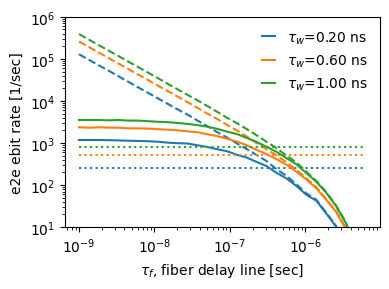

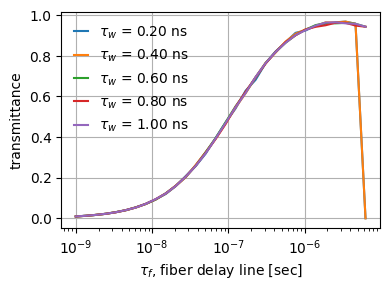

In [10]:
plt.figure(figsize=(4,3))
tolerance_list_plot = np.array(tolerance_list)[[0,2,4]]
for i_t, tolerance in enumerate(tolerance_list_plot):
    # plt.errorbar(fdl_list, (succ_rate[i_t,:,:]*trans_prob[i_t,:,:]).mean(axis=1), succ_rate[i_t,:,:].std(axis=1)/Nrep**0.5, fmt=".-", capsize=2, color = f"C{i_t}", label=fr"$\tau_w$ = {tolerance*1e9:.2f} ns")
    plt.plot(fdl_list, (succ_rate[i_t,:,:]).mean(axis=1), "--",markersize=2, color = f"C{i_t}")#, label=fr"$\tau_w$={tolerance*1e9:.2f} ns")
    plt.plot(fdl_list, (trans_prob[i_t,:,:]*succ_rate[i_t,:,:]).mean(axis=1), "-",markersize=3, color = f"C{i_t}", label=fr"$\tau_w$={tolerance*1e9:.2f} ns")
    plt.plot(fdl_list, fdl_list*0 + succ_rate_base[i_t,:].mean(), ":",markersize=3, color = f"C{i_t}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\tau_f$, fiber delay line [sec]")
plt.ylabel("e2e ebit rate [1/sec]")
plt.ylim([1e1,1e6])
plt.legend(frameon=False, handlelength=1)
# plt.grid()
plt.tight_layout()
# plt.savefig("figures/rate_vs_delay_w_loss_baseline.pdf")
# plt.savefig("figures/rate_vs_delay_w_loss_dense.pdf")
# plt.savefig("figures/rate_vs_delay_baseline.pdf")
plt.show()

# plt.figure(figsize=(4,3))
# for i_t, tolerance in enumerate(tolerance_list):
#     plt.plot(fdl_list, (trans_prob[i_t,:,:]*succ_rate[i_t,:,:]).mean(axis=1), ".-", color = f"C{i_t}", label=fr"$\tau_w$ = {tolerance*1e9:.2f} ns")

# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel(r"$\tau_f$, fiber delay line [sec]")
# plt.ylabel("e2e ebit rate [1/sec]")
# # plt.ylim([3e1,1e6])
# plt.legend(frameon=False, handlelength=1)
# plt.grid()
# plt.tight_layout()
# # plt.savefig("figures/rate_vs_delay.pdf")
# plt.show()

plt.figure(figsize=(4,3))
for i_t, tolerance in enumerate(tolerance_list):
    trans_prob_avg = np.zeros(trans_prob.shape[1])
    for i_f, fdl in enumerate(fdl_list):
        inds = np.argwhere(succ_rate[i_t,i_f,:]>0)[:,0]
        # print(inds)
        if len(inds)>0:
            trans_prob_avg[i_f] =trans_prob[i_t,i_f,inds].mean()
        else:
            trans_prob_avg[i_f] = 0
    plt.plot(fdl_list, trans_prob_avg, "-", color = f"C{i_t}", label=fr"$\tau_w$ = {tolerance*1e9:.2f} ns")

plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"$\tau_f$, fiber delay line [sec]")
plt.ylabel("transmittance")
# plt.ylim([3e1,1e6])
plt.legend(frameon=False, handlelength=1)
plt.grid()
plt.tight_layout()
# plt.savefig("figures/rate_vs_delay.pdf")
plt.show()

## baseline

In [12]:
gen_rate = 1e6 # Parameter lambda in Hz
total_time = 1e-3  # Total time in sec for the process
# tolerance_list = np.logspace(-10,-8,4) 
tolerance_list = np.arange(.2,1.1,.2)*1e-9 

Nrep = 3000
succ_rate_base = np.zeros((len(tolerance_list), Nrep))
for i_t, tolerance in enumerate(tolerance_list):
    # print(i_t, end="\r")
    tic = time.time()
    for i_r in range(Nrep):
        # print(i_r, end="\r")
        s1 = poisson_random_process(gen_rate, total_time)
        s2 = poisson_random_process(gen_rate, total_time)

        num_trials = min(s1.shape[0],s2.shape[0])
        # num_trials
        all_events = np.concatenate((s1,s2))
        events_inds = all_events.argsort()
        all_events = all_events[events_inds]
        emissions = np.zeros(events_inds.shape[0])
        emissions[np.argwhere(events_inds>=s1.shape[0])] = 1

        coincident_events = []
        coincident_inds = []
        time_diff = []
        accepted_ids = []

        i1 = 0
        photon1 = emissions[i1]
        # coincident_counter = 0
        for i_trial in range(num_trials):
            next_event = np.argwhere(emissions[i1+1:]== 1- photon1)
            if len(next_event)>0:
                i2 = i1+ next_event[0,0] +1 
                photon2 = emissions[i2]
                dt = all_events[i2]-all_events[i2-1]
                time_diff.append(dt)
                assert dt>0
                coincident_inds.append((i1,i2))
                coincident_events.append(emissions[[i1,i2]].tolist())

                i1 = i2 + 1
                if i1 < len(emissions):
                    photon1 = emissions[i1]
                else:
                    break
            else:
                break
            
        time_diff = np.array(time_diff)
        accepted_ids = np.argwhere(time_diff< tolerance)[:,0]
        succ_rate_base[i_t,i_r] = accepted_ids.shape[0]/total_time

    toc = time.time()
    print(f"{i_t}, elapsed time {toc-tic} sec")

# succ_rate /= Nrep
# print(trans_prob.mean(axis=2))

0, elapsed time 22.258883953094482 sec
1, elapsed time 22.317538022994995 sec
2, elapsed time 22.141185998916626 sec
3, elapsed time 22.25410008430481 sec
4, elapsed time 22.213851928710938 sec


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


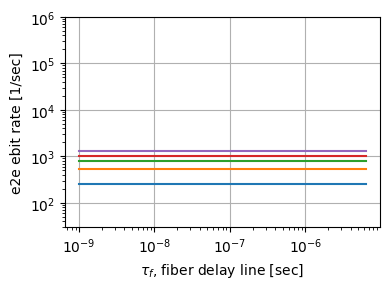

In [14]:
plt.figure(figsize=(4,3))
for i_t, tolerance in enumerate(tolerance_list):
    # plt.errorbar(fdl_list, (succ_rate[i_t,:,:]*trans_prob[i_t,:,:]).mean(axis=1), succ_rate[i_t,:,:].std(axis=1)/Nrep**0.5, fmt=".-", capsize=2, color = f"C{i_t}", label=fr"$\tau_w$ = {tolerance*1e9:.2f} ns")
    plt.plot(fdl_list,fdl_list*0+ (succ_rate[i_t,:]).mean(), "-", color = f"C{i_t}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\tau_f$, fiber delay line [sec]")
plt.ylabel("e2e ebit rate [1/sec]")
plt.ylim([3e1,1e6])
plt.legend(frameon=False, handlelength=1)
plt.grid()
plt.tight_layout()
# plt.savefig("figures/rate_vs_delay_w_loss_zoomed.pdf")
plt.show()


In [15]:
fname = f"results/rates_baseline.npz"
np.savez(fname,gen_rate, total_time,
         tolerance_list,
         succ_rate)

# two FDL scheme

In [11]:
loss_switch = 10**(-0.1*0.5)
trans = lambda t: 10**(-0.02*2e5*t)

gen_rate = 1e6 # Parameter lambda in Hz
total_time = 1e-3  # Total time in sec for the process
fdl_list = np.logspace(-9,-4.9,30) # delay line time quantization in sec
# tolerance_list = np.logspace(-10,-8,4) 
tolerance_list = np.arange(.2,1.1,.4)*1e-9 

Nrep = 10000
succ_rate = np.zeros((len(tolerance_list),len(fdl_list), Nrep))
trans_prob = np.ones((len(tolerance_list),len(fdl_list), Nrep))
for i_t, tolerance in enumerate(tolerance_list):
    # print(i_t, end="\r")
    for i_f, fdl in enumerate(fdl_list):
        tic = time.time()
        for i_r in range(Nrep):
            # print(i_r, end="\r")
            s1 = poisson_random_process(gen_rate, total_time)
            s2 = poisson_random_process(gen_rate, total_time)

            num_trials = min(s1.shape[0],s2.shape[0])
            # num_trials
            all_events = np.concatenate((s1,s2))
            events_inds = all_events.argsort()
            all_events = all_events[events_inds]
            emissions = np.zeros(events_inds.shape[0])
            emissions[np.argwhere(events_inds>=s1.shape[0])] = 1

            coincident_events = []
            coincident_inds = []
            time_diff = []
            accepted_ids = []
            trans_probs = []

            i1 = 0
            photon1 = emissions[i1]
            # coincident_counter = 0
            for i_trial in range(num_trials):
                next_event = np.argwhere(emissions[i1+1:]== 1- photon1)
                if len(next_event)>0:
                    i2 = i1+ next_event[0,0] +1 
                    photon2 = emissions[i2]
                    dt = all_events[i2]-all_events[i1]
                    time_diff.append(dt)
                    assert dt>0
                    coincident_inds.append((i1,i2))
                    coincident_events.append(emissions[[i1,i2]].tolist())
                    dt_detector = dt-(dt//fdl)*fdl
                    if min(abs(dt_detector),abs(fdl-dt_detector)) < tolerance:
                        # coincident_counter += 1
                        accepted_ids.append(i_trial)
                        if abs(dt_detector)>abs(fdl-dt_detector):
                            transmittance = loss_switch**(dt//fdl)*trans((dt//fdl+1)*fdl)
                        else:
                            transmittance = loss_switch**(dt//fdl)*trans((dt//fdl+2)*fdl)
                        trans_probs.append(transmittance)
                    i1 = i2 + 1
                    if i1 < len(emissions):
                        photon1 = emissions[i1]
                    else:
                        break
                else:
                    break
                
            time_diff = np.array(time_diff)
            succ_rate[i_t,i_f,i_r] = len(accepted_ids)/total_time
            if succ_rate[i_t,i_f,i_r]>0:
                trans_prob[i_t,i_f,i_r] = np.array(trans_probs).mean()
            #     trans_prob[i_t,i_f,i_r] = np.mean(loss_switch**(time_diff[accepted_ids]//fdl)*trans((time_diff[accepted_ids]//fdl+1)*fdl))
            # print(time_diff[accepted_ids]//fdl, loss_switch**(time_diff[accepted_ids]//fdl))
            # print(time_diff[accepted_ids],trans(time_diff[accepted_ids]))
        toc = time.time()
        print(f"({i_t},{i_f}), elapsed time {toc-tic} sec")

# succ_rate /= Nrep
# print(trans_prob.mean(axis=2))

(0,0), elapsed time 85.29304027557373 sec
(0,1), elapsed time 83.87390208244324 sec
(0,2), elapsed time 83.23580026626587 sec
(0,3), elapsed time 82.59497332572937 sec
(0,4), elapsed time 82.32554602622986 sec
(0,5), elapsed time 82.07261085510254 sec
(0,6), elapsed time 81.87292265892029 sec
(0,7), elapsed time 81.620046377182 sec
(0,8), elapsed time 81.67430901527405 sec
(0,9), elapsed time 81.77285599708557 sec
(0,10), elapsed time 81.48862409591675 sec
(0,11), elapsed time 81.05601215362549 sec
(0,12), elapsed time 81.183176279068 sec
(0,13), elapsed time 80.93238282203674 sec
(0,14), elapsed time 81.01102757453918 sec
(0,15), elapsed time 80.70632791519165 sec
(0,16), elapsed time 80.92283320426941 sec
(0,17), elapsed time 80.69266724586487 sec
(0,18), elapsed time 80.6342420578003 sec
(0,19), elapsed time 80.72409152984619 sec
(0,20), elapsed time 80.66122436523438 sec
(0,21), elapsed time 80.53789854049683 sec
(0,22), elapsed time 80.15415143966675 sec
(0,23), elapsed time 80.43

In [12]:
fname = f"results/rates_vs_delay_w_loss_second_method.npz"
np.savez(fname,gen_rate, total_time,
         fdl_list,tolerance_list,
         succ_rate,trans_prob)

In [4]:
fname = f"results/rates_vs_delay_w_loss_second_method.npz"
f1 = np.load(fname)
gen_rate = f1['arr_0'] 
total_time = f1['arr_1'] 
fdl_list =  f1['arr_2'] 
tolerance_list = f1['arr_3'] 
succ_rate = f1['arr_4'] 
trans_prob = f1['arr_5'] 


fname_base = f"results/rates_baseline.npz"
f2 = np.load(fname_base)
# tolerance_list = f2['arr_2'] 
succ_rate_base = f2['arr_3'] 


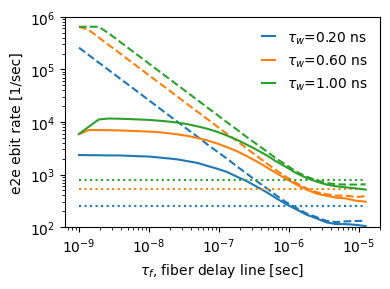

In [13]:
plt.figure(figsize=(4,3))
tolerance_list_plot = np.array(tolerance_list)[:]
for i_t, tolerance in enumerate(tolerance_list_plot):
    # plt.errorbar(fdl_list, (succ_rate[i_t,:,:]*trans_prob[i_t,:,:]).mean(axis=1), succ_rate[i_t,:,:].std(axis=1)/Nrep**0.5, fmt=".-", capsize=2, color = f"C{i_t}", label=fr"$\tau_w$ = {tolerance*1e9:.2f} ns")
    plt.plot(fdl_list, (succ_rate[i_t,:,:]).mean(axis=1), "--",markersize=2, color = f"C{i_t}")#, label=fr"$\tau_w$={tolerance*1e9:.2f} ns")
    plt.plot(fdl_list, (trans_prob[i_t,:,:]*succ_rate[i_t,:,:]).mean(axis=1), "-",markersize=3, color = f"C{i_t}", label=fr"$\tau_w$={tolerance*1e9:.2f} ns")
    plt.plot(fdl_list, fdl_list*0 + succ_rate_base[i_t,:].mean(), ":",markersize=3, color = f"C{i_t}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\tau_f$, fiber delay line [sec]")
plt.ylabel("e2e ebit rate [1/sec]")
plt.ylim([1e2,1e6])
plt.legend(frameon=False, handlelength=1)
# plt.grid()
plt.tight_layout()
# plt.savefig("figures/rate_vs_delay_w_loss_baseline.pdf")
# plt.savefig("figures/rate_vs_delay_w_loss_dense.pdf")
# plt.savefig("figures/rate_vs_delay_baseline.pdf")
plt.show()


In [5]:


print(time_diff[:10])
print(coincident_inds[:10])
print(coincident_events[:10])


[7.30633936289419e-07, 3.2867132785075145e-06, 1.4341142256975026e-06, 1.6051239839690611e-06, 9.825256751407595e-07, 4.360820695205129e-06, 7.102901885558037e-07, 1.778141563800896e-06, 7.919815672620779e-07, 2.016163873606087e-06]
[(0, 1), (2, 4), (5, 6), (7, 11), (12, 13), (14, 20), (21, 22), (23, 26), (27, 29), (30, 31)]
[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]


In [80]:

# s2 = poisson_random_process(gen_rate, total_time)
# # print("Event timestamps:", event_timestamps)
# np.sum(s1==s2)

# gen_rate = 1e6 
# Niter = 1e4
# # s1 = np.random.poisson(gen_rate, Niter)
# # s2 = np.random.poisson(gen_rate, Niter)
# # np.argwhere(s1==s2)

912